# Workshop 4

Starter code for workshop 4. You should have seen most of it before, but make sure you understand what it is doing!

In [1]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To plot even prettier figures
import seaborn as sn

# General data handling (pure numerics are better in numpy)
import pandas as pd

In [2]:
# Load the dataset

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
# This is where the numerical data is
xarray = data.data
yarray = data.target

In [4]:
# This is where the names of features and targets are
print(f'Features names are: {data.feature_names}')
print(f'Label names are: {data.target_names}')

Features names are: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Label names are: ['malignant' 'benign']


In [5]:
# We recommend inverting the labels so that malignant (the worse disease) = 1 (i.e. positive)
yarray = 1 - yarray
# Don't forget to switch the label names too (if you are going to use them anywhere)
# Though it is good practice to switch them here anyway, as future modifications to the code then won't get confused

In [6]:
# This is how you could put it all into a pandas dataframe (useful for some investigations)
fullarray = np.concatenate((xarray,np.reshape(yarray,(-1,1))),axis=1)
df = pd.DataFrame(fullarray, columns = list(data.feature_names) + ['target'])

# Splitting into separate datasets

In [7]:
from sklearn.model_selection import train_test_split

bigtrain_set,test_set = train_test_split(df,test_size=0.2, random_state = 20)
train_set, val_set = train_test_split(bigtrain_set, test_size=0.2, random_state=20)

X_train = train_set.iloc[:,:-1]
y_train = train_set.iloc[:,-1]
X_test = test_set.iloc[:,:-1]
y_test = test_set.iloc[:,-1]
X_val = val_set.iloc[:,:-1]
y_val = val_set.iloc[:,-1]
print([X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape])

[(364, 30), (364,), (114, 30), (114,), (91, 30), (91,)]


# Pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Create preprocessing pipeline
preprocessing_pipeline = Pipeline([
    # Step 1: Handle missing values (if any)
    ('imputer', SimpleImputer(strategy='median')),
    
    # Step 2: Standardize features
    # This is important because the features are on different scales
    # (mean radius vs mean texture vs mean area have very different ranges)
    ('scaler', StandardScaler()),
])

# Apply the pipeline to each split individually (so the test data doesn't influence training data)
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)
X_test_processed = preprocessing_pipeline.transform(X_test)

# SGD Classifier

First 10 binary predictions: [0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
First 10 probability predictions: [1.15469494e-05 1.00000000e+00 1.00000000e+00 6.78695409e-25
 9.99999084e-01 1.00000000e+00 1.95644798e-24 3.89330365e-20
 3.09673844e-22 2.99704861e-11]


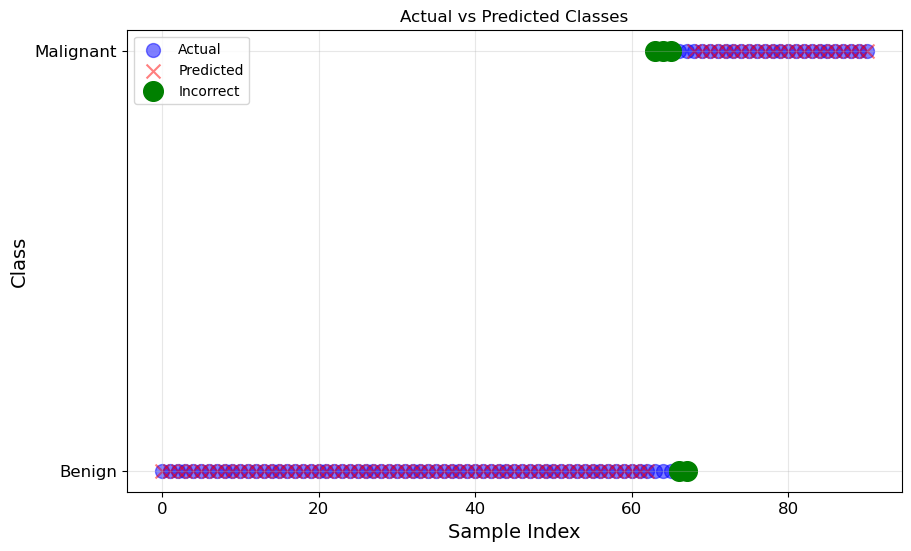

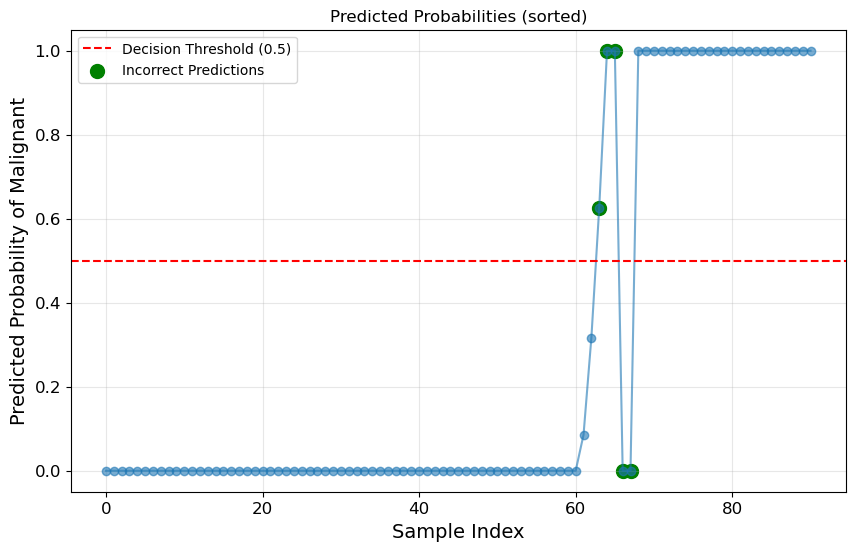

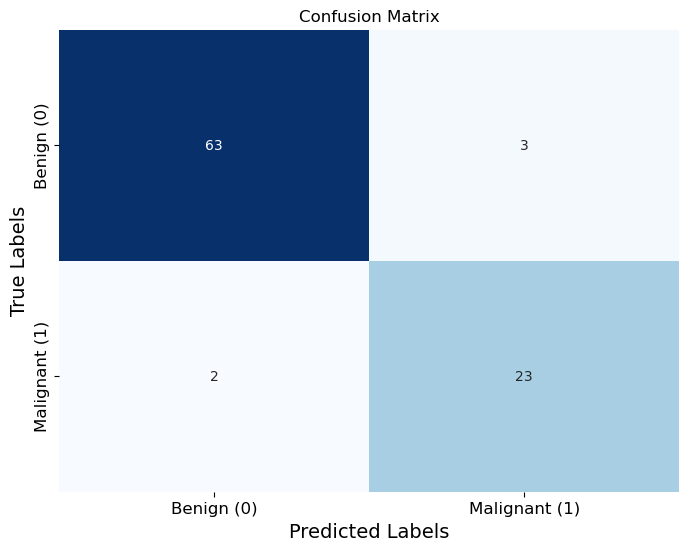

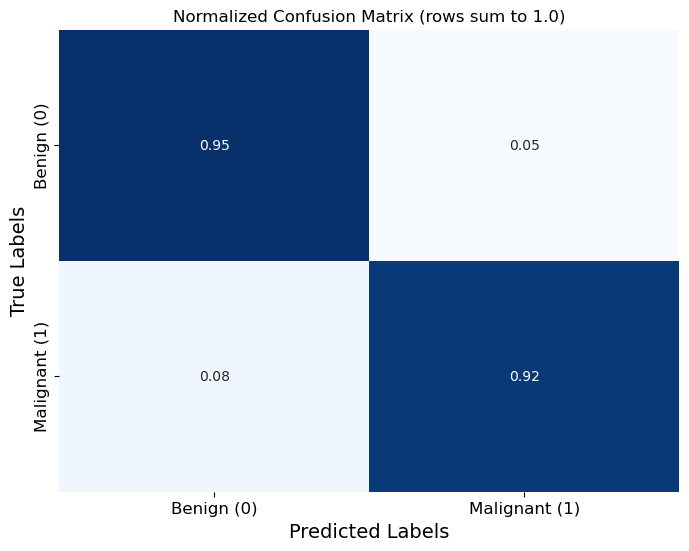

Accuracy: 0.9451
Precision: 0.8846
Recall: 0.9200
F1 Score: 0.9020
Number of distinct points in ROC curve using binary predictions: 3
Thresholds: [inf  1.  0.]


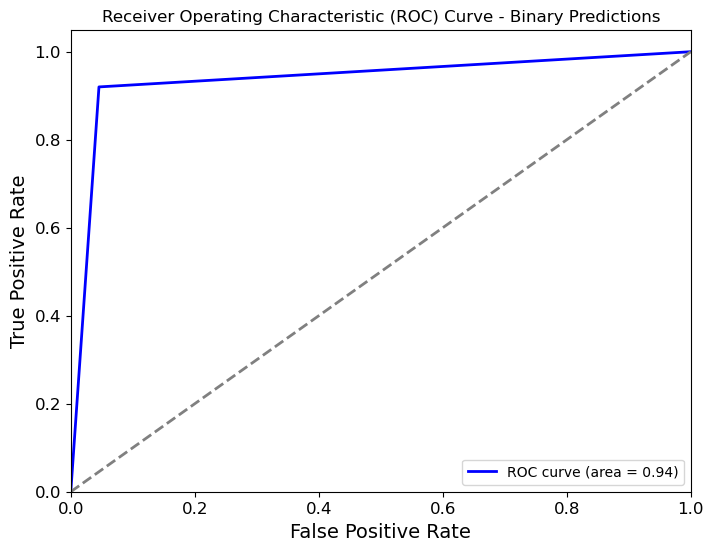

Number of distinct points in ROC curve using probability predictions: 10


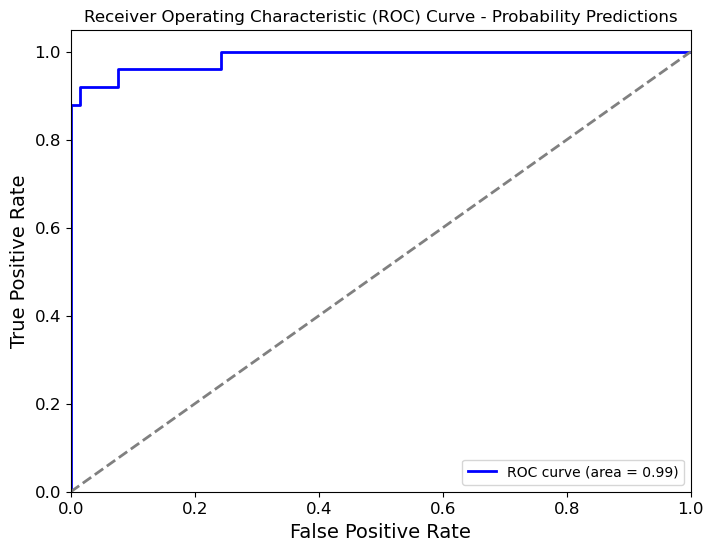


Wrong predictions:
Sample 9: True=1.0, Pred=0.0, Prob=0.0000
Sample 15: True=0.0, Pred=1.0, Prob=0.9999
Sample 44: True=0.0, Pred=1.0, Prob=1.0000
Sample 52: True=0.0, Pred=1.0, Prob=0.6248
Sample 72: True=1.0, Pred=0.0, Prob=0.0003
For wrong prediction with prob 0.0000, closest threshold: 0.0000
For wrong prediction with prob 0.9999, closest threshold: 1.0000
For wrong prediction with prob 1.0000, closest threshold: 1.0000
For wrong prediction with prob 0.6248, closest threshold: 1.0000
For wrong prediction with prob 0.0003, closest threshold: 0.0003


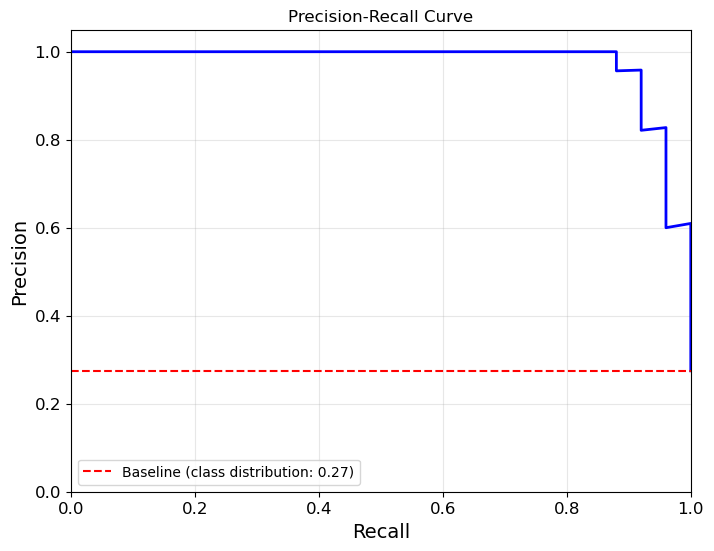

   Threshold  Accuracy  Precision  Recall  F1 Score
0        0.3  0.934066   0.851852    0.92  0.884615
1        0.5  0.945055   0.884615    0.92  0.901961
2        0.7  0.956044   0.920000    0.92  0.920000
3        0.9  0.956044   0.920000    0.92  0.920000


In [10]:
# Import necessary libraries
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a pipeline that includes preprocessing and SGD classifier
# We'll use the preprocessing pipeline we defined earlier
sgd_pipeline = Pipeline([
    # First, include all preprocessing steps
    ('preprocessor', preprocessing_pipeline),
    # Then add the SGD classifier
    ('classifier', SGDClassifier(loss='log', random_state=42))
])

# Train the model on the training data
sgd_pipeline.fit(X_train, y_train)

# Get binary predictions (0 or 1)
y_val_pred = sgd_pipeline.predict(X_val)

# Get probability predictions (chance of being class 1)
# The second column [[:,1]] gives the probability of the positive class (1)
y_val_prob = sgd_pipeline.predict_proba(X_val)[:,1]

print("First 10 binary predictions:", y_val_pred[:10])
print("First 10 probability predictions:", y_val_prob[:10])

# Create a plot to visualize predictions vs actual values
plt.figure(figsize=(10, 6))

# Sort by actual values and then by predicted probabilities for better visualization
sort_idx = np.lexsort((y_val_prob, y_val))
sorted_y_val = y_val.values[sort_idx]
sorted_y_val_pred = y_val_pred[sort_idx]
sorted_y_val_prob = y_val_prob[sort_idx]

# Plot actual values
plt.scatter(range(len(sorted_y_val)), sorted_y_val, c='blue', label='Actual', alpha=0.5, s=100)

# Plot predicted values
plt.scatter(range(len(sorted_y_val_pred)), sorted_y_val_pred, c='red', marker='x', label='Predicted', alpha=0.5, s=100)

# Highlight incorrect predictions
incorrect = sorted_y_val != sorted_y_val_pred
plt.scatter(np.where(incorrect)[0], sorted_y_val_pred[incorrect], c='green', marker='o', s=200, facecolors='none', label='Incorrect')

plt.yticks([0, 1], ['Benign', 'Malignant'])
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('Actual vs Predicted Classes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Also create a plot of the probability predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_y_val_prob)), sorted_y_val_prob, 'o-', alpha=0.6)
plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Threshold (0.5)')
plt.scatter(np.where(incorrect)[0], sorted_y_val_prob[incorrect], c='green', s=100, label='Incorrect Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability of Malignant')
plt.title('Predicted Probabilities (sorted)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Benign (0)', 'Malignant (1)'])
plt.yticks([0.5, 1.5], ['Benign (0)', 'Malignant (1)'])
plt.show()

# Calculate and display normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (rows sum to 1.0)')
plt.xticks([0.5, 1.5], ['Benign (0)', 'Malignant (1)'])
plt.yticks([0.5, 1.5], ['Benign (0)', 'Malignant (1)'])
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {2 * (precision * recall) / (precision + recall):.4f}")

# Calculate ROC curve using binary predictions
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Binary Predictions')
plt.legend(loc="lower right")
print(f"Number of distinct points in ROC curve using binary predictions: {len(fpr)}")
print(f"Thresholds: {thresholds}")
plt.show()

# Calculate ROC curve using probability predictions
fpr_prob, tpr_prob, thresholds_prob = roc_curve(y_val, y_val_prob)

# Calculate Area Under the Curve (AUC)
roc_auc_prob = auc(fpr_prob, tpr_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_prob, tpr_prob, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_prob:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Probability Predictions')
plt.legend(loc="lower right")
print(f"Number of distinct points in ROC curve using probability predictions: {len(fpr_prob)}")
plt.show()

# Let's look at wrong predictions and their probabilities
wrong_idx = np.where(y_val != y_val_pred)[0]
wrong_probs = y_val_prob[wrong_idx]
wrong_true = y_val.values[wrong_idx]
wrong_pred = y_val_pred[wrong_idx]

print("\nWrong predictions:")
for i, idx in enumerate(wrong_idx):
    print(f"Sample {idx}: True={wrong_true[i]}, Pred={wrong_pred[i]}, Prob={wrong_probs[i]:.4f}")

# Find closest thresholds to the wrong prediction probabilities
for wrong_prob in wrong_probs:
    closest_idx = np.argmin(np.abs(thresholds_prob - wrong_prob))
    print(f"For wrong prediction with prob {wrong_prob:.4f}, closest threshold: {thresholds_prob[closest_idx]:.4f}")

# Calculate precision-recall curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_val_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.axhline(y=sum(y_val)/len(y_val), color='red', linestyle='--', label=f'Baseline (class distribution: {sum(y_val)/len(y_val):.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

# Look at different thresholds and their effect on precision and recall
threshold_examples = [0.3, 0.5, 0.7, 0.9]
results = []

for threshold in threshold_examples:
    # Convert probabilities to binary predictions based on threshold
    y_pred_custom = (y_val_prob >= threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_val, y_pred_custom)
    prec = precision_score(y_val, y_pred_custom)
    rec = recall_score(y_val, y_pred_custom)
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    
    results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

# Display results as a dataframe
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Decision Tree

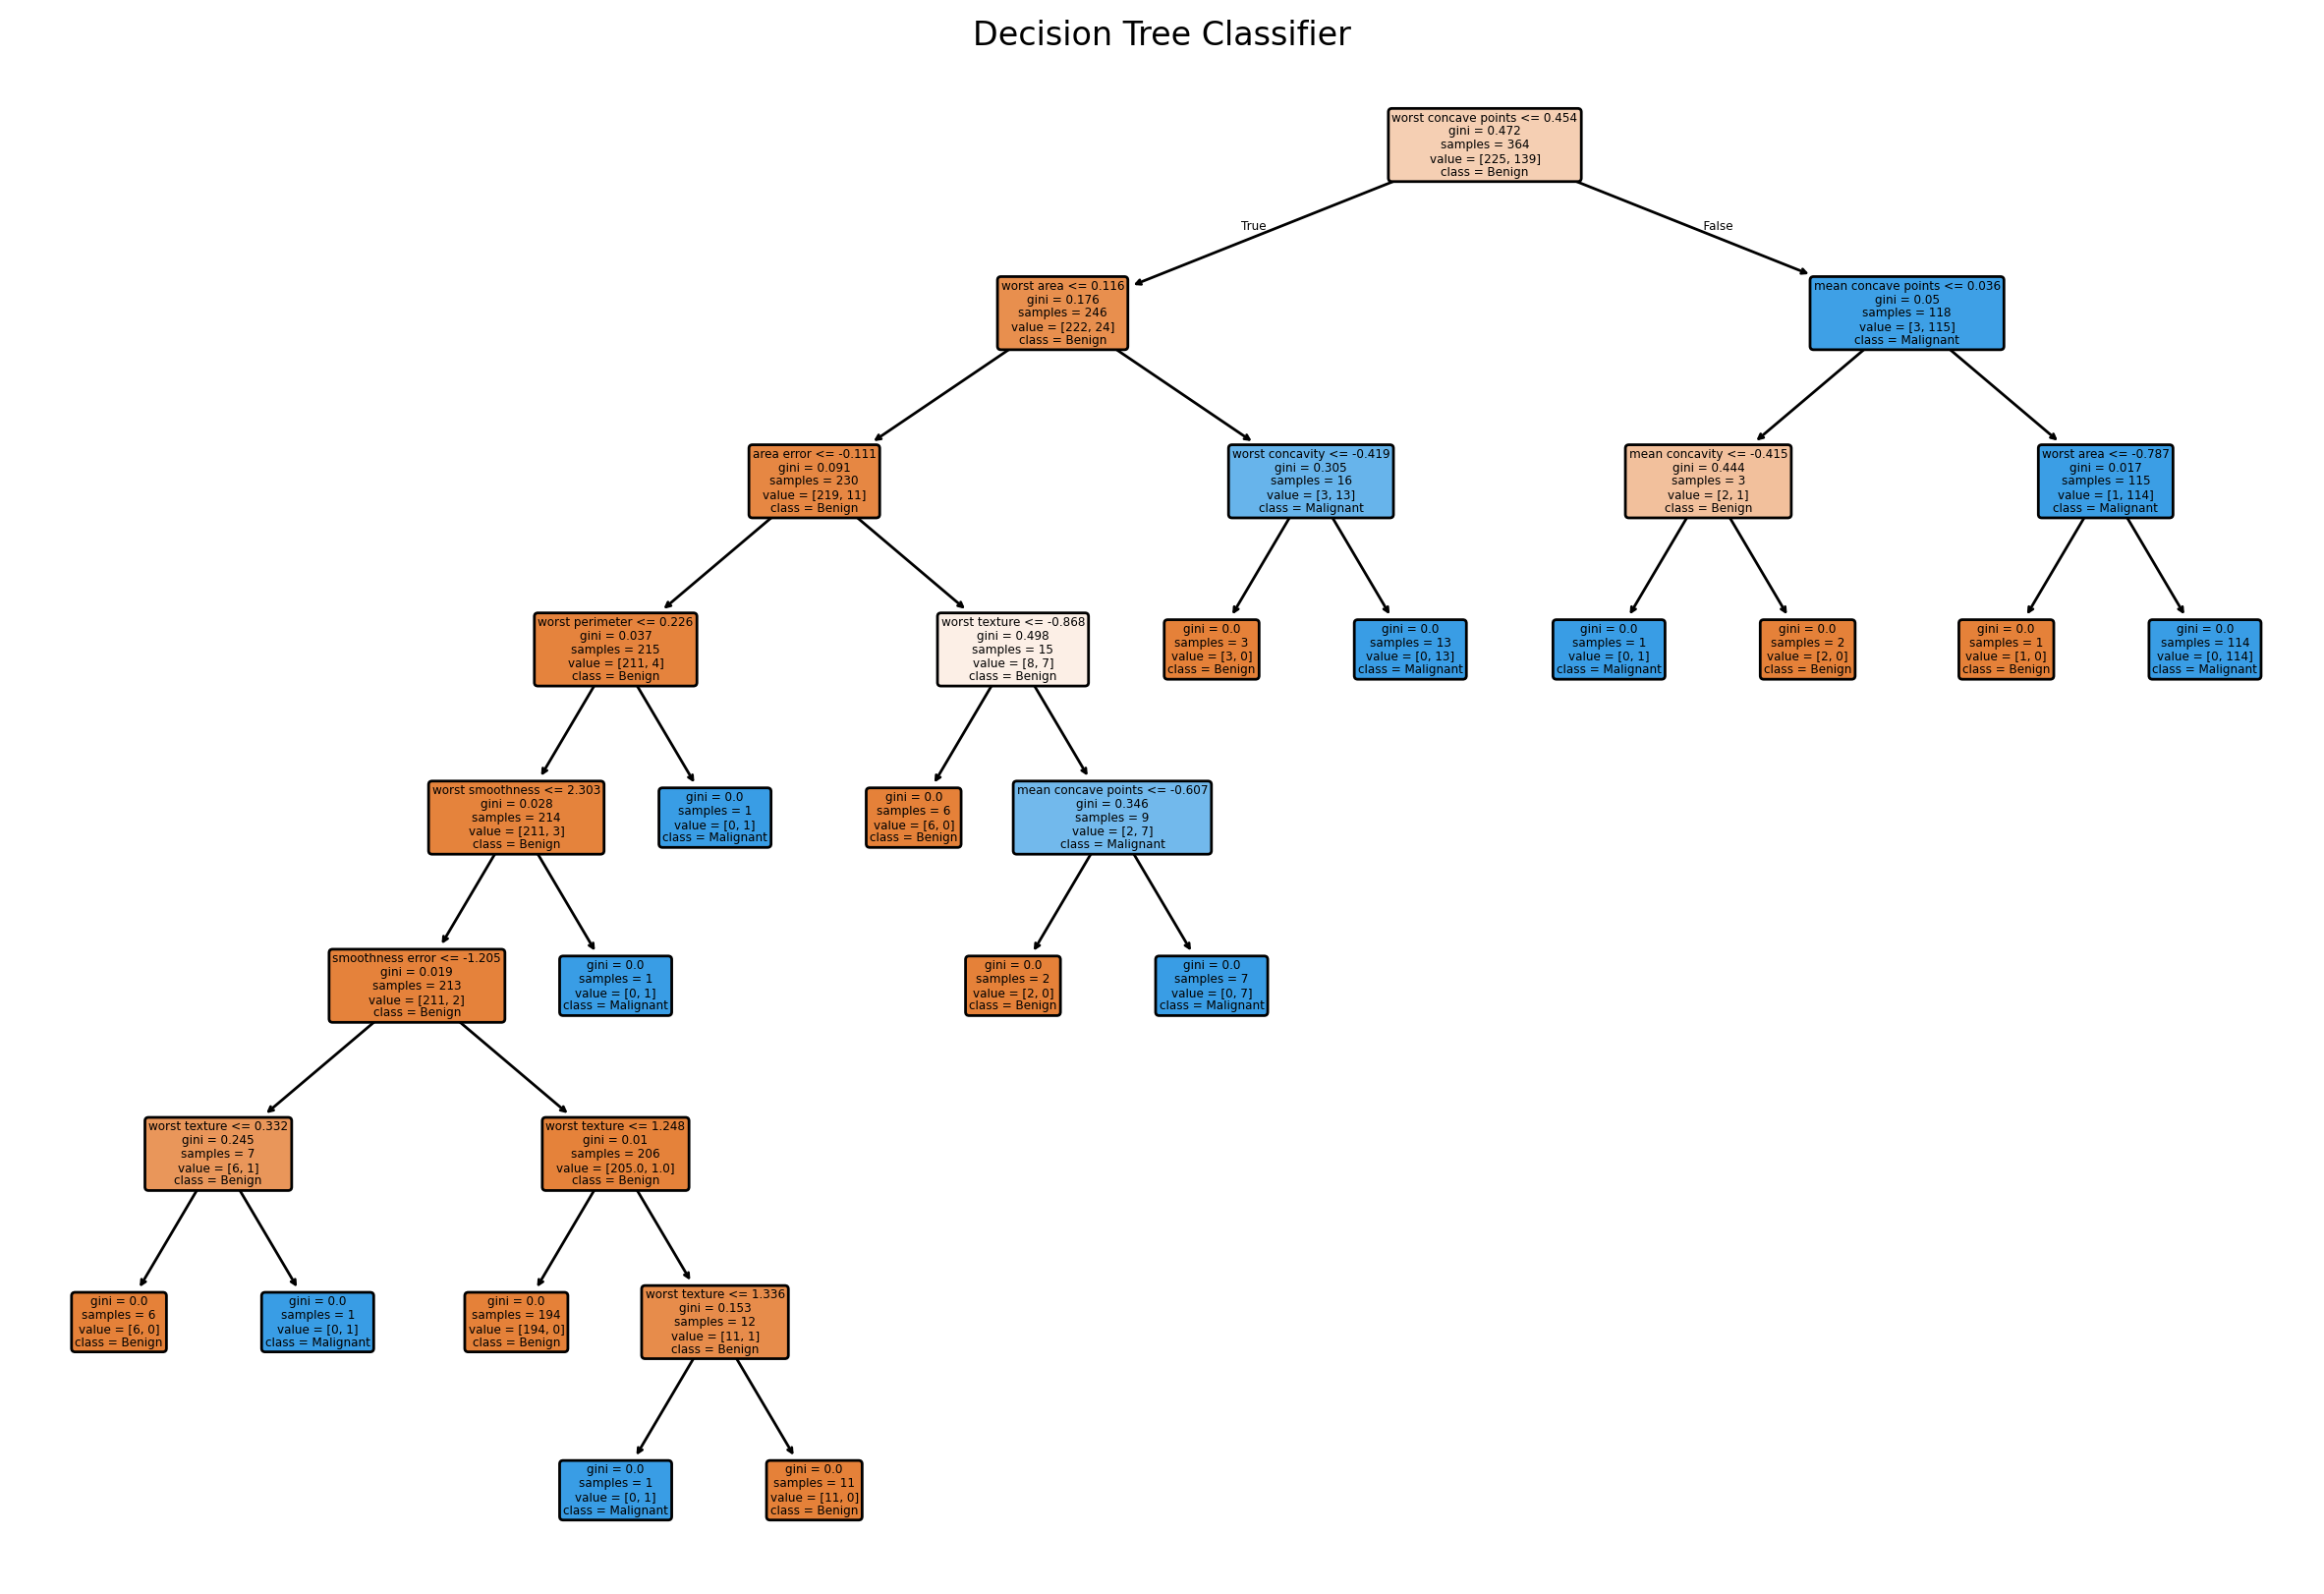

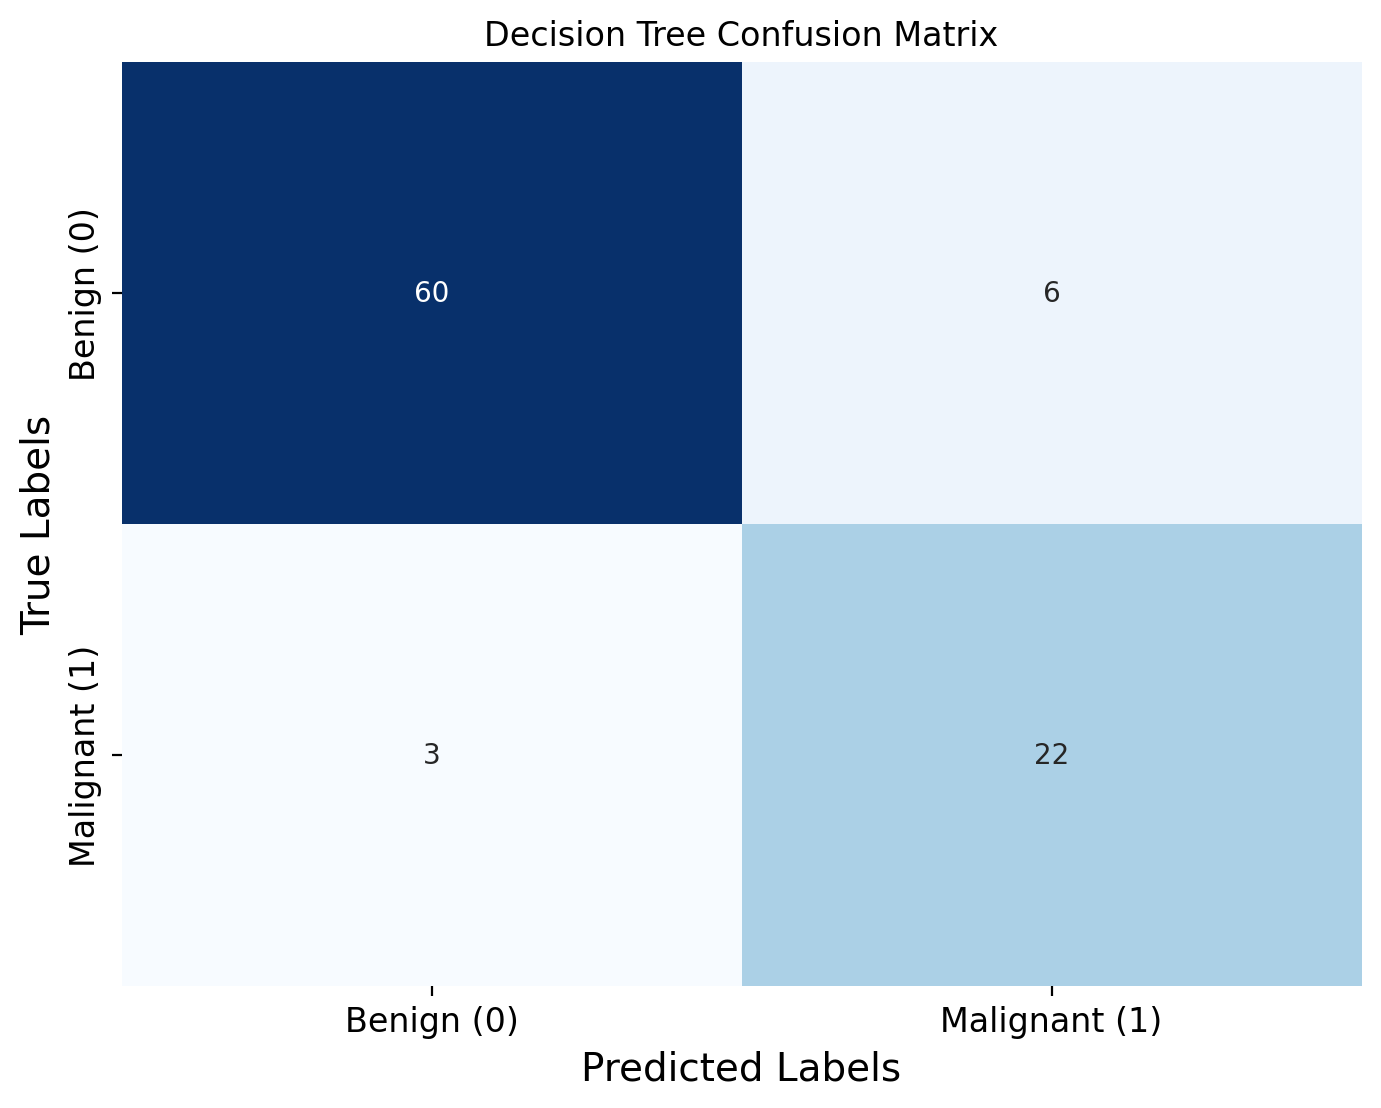

Decision Tree Precision: 0.7857
Decision Tree Recall: 0.8800
Number of distinct points in ROC curve for Decision Tree: 3


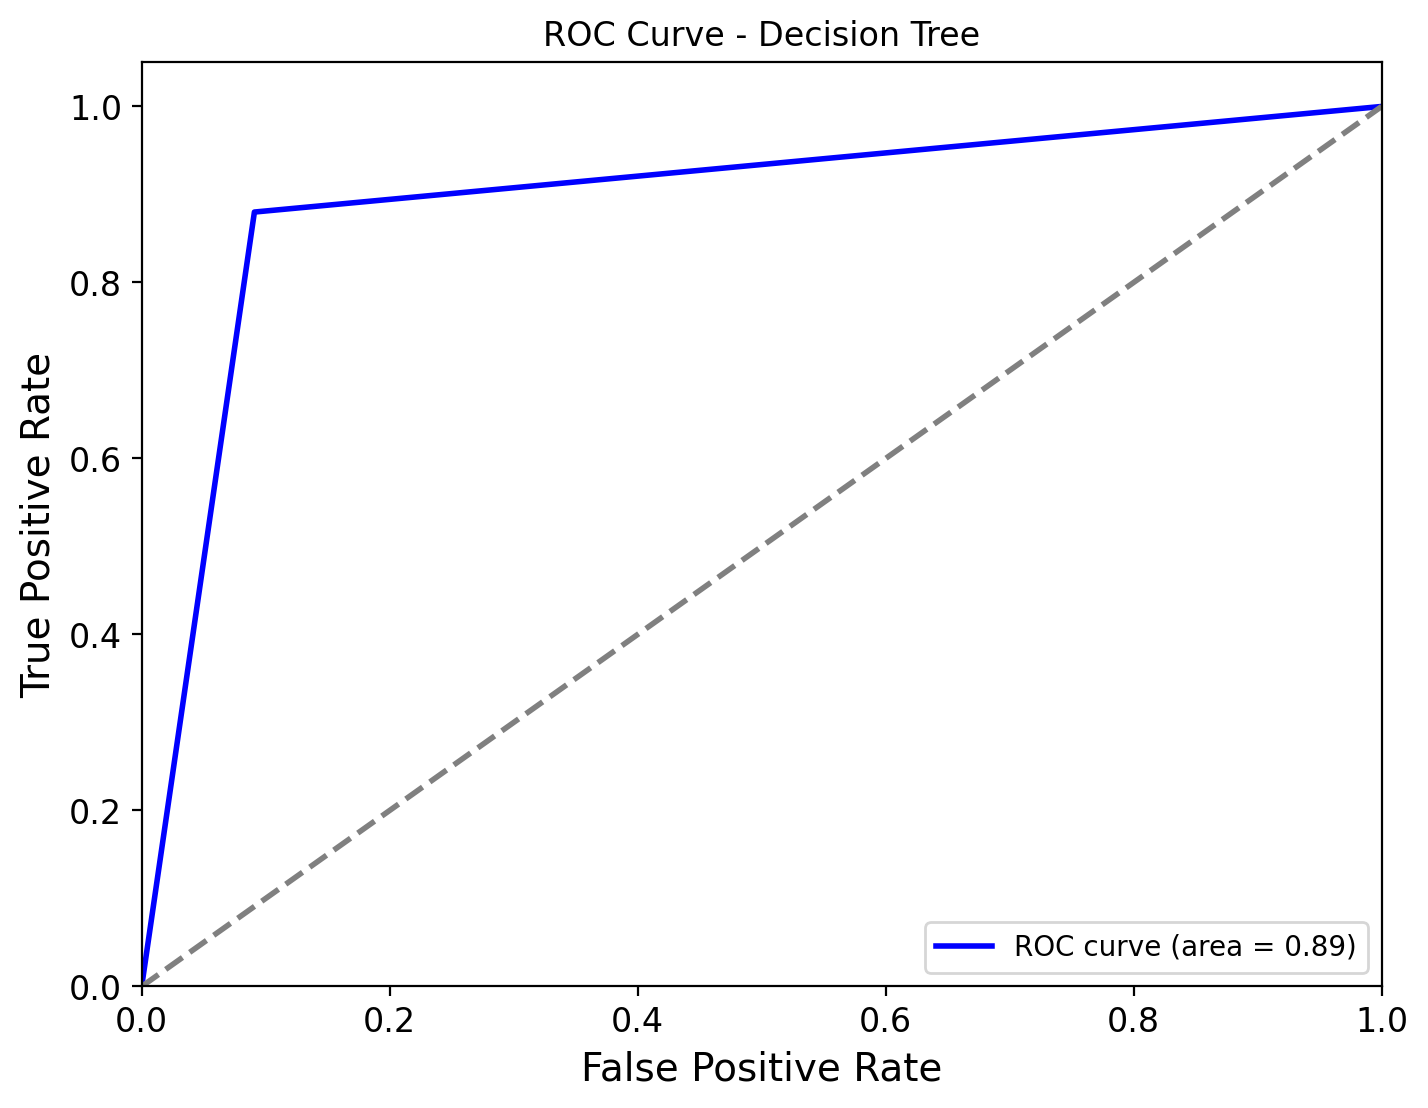

'\nWhat do each of the components of the decision tree mean?\n\nNodes: Represent tests on a particular feature. The root node represents the entire dataset.\n\nInternal nodes: Show a decision based on a feature value\nLeaf nodes: Show the final classification outcome\n\n\nBranches: Represent the outcome of a test and connect nodes\n\nTypically, branches show "True" or "False" paths based on the condition at each node\n\n\nThresholds: The value at which a split occurs for a particular feature\n\nFor example: "worst concave points ≤ 0.136" means if this feature is less than or equal to 0.136, follow the left branch, otherwise follow the right branch\n\n\n\nWhy are there so few points in the ROC curve? Does it still show useful information?\nFor decision trees, there will be very few points in the ROC curve (often just 1-3 points) because:\n\nDecision trees make "hard" binary decisions without natural probability outputs\nA standard decision tree can only output a limited number of differ

In [12]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc

# Increase the resolution for the decision tree plot
plt.rcParams['figure.dpi'] = 200

# Create and train a decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_processed, y_train)

# Display the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, feature_names=X_train.columns, class_names=['Benign', 'Malignant'], 
          filled=True, rounded=True)
plt.title('Decision Tree Classifier')
plt.show()

# Apply the classifier to the validation set
y_val_dt_pred = dt_classifier.predict(X_val_processed)

# Calculate confusion matrix
cm_dt = confusion_matrix(y_val, y_val_dt_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Decision Tree Confusion Matrix')
plt.xticks([0.5, 1.5], ['Benign (0)', 'Malignant (1)'])
plt.yticks([0.5, 1.5], ['Benign (0)', 'Malignant (1)'])
plt.show()

# Calculate precision and recall
dt_precision = precision_score(y_val, y_val_dt_pred)
dt_recall = recall_score(y_val, y_val_dt_pred)
print(f"Decision Tree Precision: {dt_precision:.4f}")
print(f"Decision Tree Recall: {dt_recall:.4f}")

# Calculate and plot ROC curve
# For decision trees, we need to use decision_function or predict_proba
# Since single decision trees don't have a natural way to get probabilities for ROC,
# we'll use the class predictions as a rough approximation
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, y_val_dt_pred)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
print(f"Number of distinct points in ROC curve for Decision Tree: {len(fpr_dt)}")
plt.show()

'''
What do each of the components of the decision tree mean?

Nodes: Represent tests on a particular feature. The root node represents the entire dataset.

Internal nodes: Show a decision based on a feature value
Leaf nodes: Show the final classification outcome


Branches: Represent the outcome of a test and connect nodes

Typically, branches show "True" or "False" paths based on the condition at each node


Thresholds: The value at which a split occurs for a particular feature

For example: "worst concave points ≤ 0.136" means if this feature is less than or equal to 0.136, follow the left branch, otherwise follow the right branch



Why are there so few points in the ROC curve? Does it still show useful information?
For decision trees, there will be very few points in the ROC curve (often just 1-3 points) because:

Decision trees make "hard" binary decisions without natural probability outputs
A standard decision tree can only output a limited number of different values (0 or 1)

The ROC curve still shows some useful information about the overall performance, but it's much less granular than the SGD classifier's curve. It essentially shows you the operating point of the decision tree rather than a range of possible thresholds.
How does the decision tree compare to the SGD linear model? List 2 pros and 2 cons of each approach.
Decision Tree pros:

Easy to interpret and visualize (you can see exactly how decisions are made)
Can capture non-linear relationships in the data
Doesn't require feature scaling (unlike SGD)
Handles categorical features natively

Decision Tree cons:

Prone to overfitting, especially with deeper trees
Less stable (small changes in data can lead to very different trees)
Doesn't provide probability outputs as naturally as SGD with logistic loss
Often less accurate than other methods for many real-world problems

SGD Linear Model pros:

Can provide probability estimates (with log_loss)
Often works well even with limited data
More stable (small changes in data lead to small changes in the model)
Regularization options help prevent overfitting

SGD Linear Model cons:

Limited to linear decision boundaries (can't capture complex relationships without feature engineering)
Feature scaling is required for good performance
Less interpretable than decision trees
May not perform well when classes are not linearly separable
'''

# Model selection

In [13]:
# Let's calculate various metrics for both models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# For SGD Classifier
sgd_accuracy = accuracy_score(y_val, y_val_pred)
sgd_precision = precision_score(y_val, y_val_pred)
sgd_recall = recall_score(y_val, y_val_pred)
sgd_f1 = f1_score(y_val, y_val_pred)
sgd_auc = roc_auc_score(y_val, y_val_prob)

# For Decision Tree
dt_accuracy = accuracy_score(y_val, y_val_dt_pred)
dt_precision = precision_score(y_val, y_val_dt_pred)
dt_recall = recall_score(y_val, y_val_dt_pred)
dt_f1 = f1_score(y_val, y_val_dt_pred)
# Note: For AUC with decision trees, we'll need predict_proba
dt_prob = dt_classifier.predict_proba(X_val_processed)[:, 1]
dt_auc = roc_auc_score(y_val, dt_prob)

# Compare all metrics
print("Metrics Comparison:")
print(f"{'Metric':<10} | {'SGD':<10} | {'Decision Tree':<15}")
print("-" * 40)
print(f"{'Accuracy':<10} | {sgd_accuracy:.4f} | {dt_accuracy:.4f}")
print(f"{'Precision':<10} | {sgd_precision:.4f} | {dt_precision:.4f}")
print(f"{'Recall':<10} | {sgd_recall:.4f} | {dt_recall:.4f}")
print(f"{'F1-Score':<10} | {sgd_f1:.4f} | {dt_f1:.4f}")
print(f"{'AUC':<10} | {sgd_auc:.4f} | {dt_auc:.4f}")

# Choose the model with better recall
if sgd_recall >= dt_recall:
    print("SGD classifier has better recall. Selecting this model.")
    chosen_model = sgd_pipeline
else:
    print("Decision Tree has better recall. Selecting this model.")
    chosen_model = Pipeline([
        ('preprocessor', preprocessing_pipeline),
        ('classifier', dt_classifier)
    ])

# Combine training and validation data
import numpy as np
X_train_combined = pd.concat([X_train, X_val])
y_train_combined = pd.concat([y_train, y_val])

# Retrain the chosen model on combined data
chosen_model.fit(X_train_combined, y_train_combined)

# Evaluate on test set
y_test_pred = chosen_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Compare validation and test performance for recall
chosen_model_name = "SGD" if sgd_recall >= dt_recall else "Decision Tree"
chosen_val_recall = sgd_recall if sgd_recall >= dt_recall else dt_recall
print(f"\nRecall comparison for {chosen_model_name}:")
print(f"Validation set: {chosen_val_recall:.4f}")
print(f"Test set: {test_recall:.4f}")
print(f"Difference: {abs(chosen_val_recall - test_recall):.4f}")

Metrics Comparison:
Metric     | SGD        | Decision Tree  
----------------------------------------
Accuracy   | 0.9451 | 0.9011
Precision  | 0.8846 | 0.7857
Recall     | 0.9200 | 0.8800
F1-Score   | 0.9020 | 0.8302
AUC        | 0.9867 | 0.8945
SGD classifier has better recall. Selecting this model.

Test Set Performance:
Accuracy: 0.9912
Precision: 0.9796
Recall: 1.0000
F1 Score: 0.9897

Recall comparison for SGD:
Validation set: 0.9200
Test set: 1.0000
Difference: 0.0800


In [14]:
# Make a copy of the predictions
y_test_pred_modified = y_test_pred.copy()

# Flip one prediction (choose an index randomly)
import random
flip_index = random.randint(0, len(y_test_pred_modified) - 1)
y_test_pred_modified[flip_index] = 1 - y_test_pred_modified[flip_index]

# Recalculate metrics
mod_accuracy = accuracy_score(y_test, y_test_pred_modified)
mod_precision = precision_score(y_test, y_test_pred_modified)
mod_recall = recall_score(y_test, y_test_pred_modified)
mod_f1 = f1_score(y_test, y_test_pred_modified)

print("\nStability Test - Effect of Flipping One Prediction:")
print(f"{'Metric':<10} | {'Original':<10} | {'Modified':<10} | {'Change':<10}")
print("-" * 50)
print(f"{'Accuracy':<10} | {test_accuracy:.4f} | {mod_accuracy:.4f} | {mod_accuracy - test_accuracy:.4f}")
print(f"{'Precision':<10} | {test_precision:.4f} | {mod_precision:.4f} | {mod_precision - test_precision:.4f}")
print(f"{'Recall':<10} | {test_recall:.4f} | {mod_recall:.4f} | {mod_recall - test_recall:.4f}")
print(f"{'F1-Score':<10} | {test_f1:.4f} | {mod_f1:.4f} | {mod_f1 - test_f1:.4f}")


Stability Test - Effect of Flipping One Prediction:
Metric     | Original   | Modified   | Change    
--------------------------------------------------
Accuracy   | 0.9912 | 0.9825 | -0.0088
Precision  | 0.9796 | 0.9600 | -0.0196
Recall     | 1.0000 | 1.0000 | 0.0000
F1-Score   | 0.9897 | 0.9796 | -0.0101
